Semestral work from MPI - Recommend articles for images

Install SentenceTransformers which I will use to encode sentences - part of articles. 

In [1]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.9 MB/s 
     |████████████████████████████████| 5.8 MB 29.4 MB/s 
     |████████████████████████████████| 1.3 MB 52.2 MB/s 
     |████████████████████████████████| 182 kB 69.7 MB/s 
     |████████████████████████████████| 7.6 MB 55.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=ec3b29858cb67d8373a10da69a917703b143fd713f231542ae5d4d7c64948215
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
!nvidia-smi

Mon Nov 14 17:45:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# imports

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import json
from skimage import io
import cv2 as cv
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
import re

drive.mount('/content/drive')

Mounted at /content/drive


Download desired dataset and unzip it.

In [3]:
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [4]:
!mkdir /train_data
!gdown -O /train_data/wikipedia_articles_with_images 1l0Oyv2Y6LmPGN3lP9MB6i8WWCinqkYPk

Downloading...
From: https://drive.google.com/uc?id=1l0Oyv2Y6LmPGN3lP9MB6i8WWCinqkYPk
To: /train_data/wikipedia_articles_with_images
100% 6.95G/6.95G [01:00<00:00, 115MB/s]


In [5]:
!unzip /train_data/wikipedia_articles_with_images -d /train_data/wikipedia_articles

Streaming output truncated to the last 5000 lines.
   creating: /train_data/wikipedia_articles/data/Valley_View_(Romney,_West_Virginia)/img/
  inflating: /train_data/wikipedia_articles/data/Valley_View_(Romney,_West_Virginia)/img/6c3d21abc0d37656f1245f7e5254c935.jpg  
  inflating: /train_data/wikipedia_articles/data/Valley_View_(Romney,_West_Virginia)/img/6cc474c11e6076f276ee26a9087c94fe.jpg  
  inflating: /train_data/wikipedia_articles/data/Valley_View_(Romney,_West_Virginia)/img/8b6af605b21198d31cc9200c0a1cb5c9.jpg  
  inflating: /train_data/wikipedia_articles/data/Valley_View_(Romney,_West_Virginia)/img/cbbf638146bd76dbb86e6eb092b9e72f.jpg  
  inflating: /train_data/wikipedia_articles/data/Valley_View_(Romney,_West_Virginia)/img/d2214086728cd2bf83983ffe523cb179.jpg  
  inflating: /train_data/wikipedia_articles/data/Valley_View_(Romney,_West_Virginia)/img/f545d17958d3acd6267cd3ac5042ed62.jpg  
  inflating: /train_data/wikipedia_articles/data/Valley_View_(Romney,_West_Virginia)/img/me

Split text into pieces of certain length which overlap in certain amount of words

In [ ]:
def split_text(text, max_len=256, overlap=128):
  # replace newline with space
  text = text.replace('\n', ' ')
  # remove special characters
  escape_chars = "".join([chr(char) for char in range(1, 32)])
  text = text.translate(str.maketrans('', '', escape_chars))
  # remove non alphanumeric characters
  text = re.sub(r'[^\w\s]', '', text)
  words = text.split()
  text_len = len(words)
  if text_len <= max_len:
    # no need to split
    return [text]

  parts = [" ".join(words[:max_len])]
  num_of_parts = text_len // (max_len - overlap)
  for part_idx in range(1, num_of_parts):
    start = part_idx * overlap
    parts.append(" ".join(words[start:(start + max_len)]))

  return parts

In [ ]:
def encode_article(sentence_transformer, article_content):
  parts = split_text(article_content)
  embeddings = sentence_transformer.encode(parts, convert_to_tensor=True)
  embedding = torch.sum(embeddings, dim=0)
  return embedding

Create dataset class

In [6]:
class WikipediaArticlesDataset(Dataset):
  def __init__(self, directory, sentence_transformer, transform=None, target_transform=None):
    # have to pre process dataset, otherwise I would not know how many images there are
    images = []
    # check directory of each article
    for article_dir in os.listdir(directory):
      path = os.path.join(directory, article_dir)
      if os.path.isdir(path):
        text_path = os.path.join(path, 'text.json')
        img_path = os.path.join(path, 'img')
        with open(text_path, 'r') as text_file:
          # extract article text
          text_data = json.load(text_file)
          text_data = json.loads(text_data)
          # content = text_data['text']
          content = text_data['title']
          # get article embedding
          # article_embedding = encode_article(sentence_transformer, content)
          article_embedding = sentence_transformer.encode([content])
          # list all available images and add them to list
          for img_data in os.listdir(img_path):
            if img_data != 'meta.json':
              image_name = os.path.join(img_path, img_data)
              images.append([image_name, article_embedding])
 
    self.images = images
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    image_path = self.images[idx][0]
    try:
      # PIL image loader
      image = Image.open(image_path)
      # some images are just grayscale, some have even more than 3 channels -> convert them all to RGB
      image = image.convert("RGB")
    except:
      # image not found
      return self.__getitem__(idx - 1)
    label = self.images[idx][1]
    
    # perform transforms
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    return image, label

In [7]:
# I have chosen all-MiniLM-L6-v2 model, because it offers very good performance and small model size while maintaining prety good quality
# Embedding of each sentence has 384 dimensions, sentence can contain up to 256 words
sentence_transformer_model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Load dataset and split it to train and test part

In [8]:
# resize and normalize images
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5), (0.5))
])

full_dataset = WikipediaArticlesDataset('/train_data/wikipedia_articles/data', sentence_transformer_model, transform=transform)
# split dataset into train and test part
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

Check random image

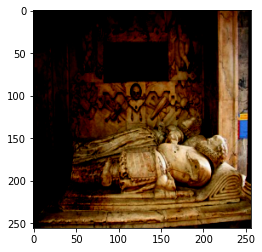

In [ ]:
plt.imshow(next(iter(train_loader))[0][45].permute(1,2,0))

Prepare Convolutional Neural Network

In [10]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    # [Conv, ReLU, Conv, ReLu, Pool] * 4
    self.convolutional_layer = nn.Sequential(
        # out 48 X 126 X 126
        nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(5,5), stride=(2,2)),
        nn.ReLU(),

        # out 48 X 122 X 212
        nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(5,5), stride=(1,1)),
        nn.ReLU(),
        # out 48 X 61 X 61
        nn.MaxPool2d(2,2),
        # batch for 48 channels
        nn.BatchNorm2d(48),

        # out 96 X 59 X 59
        nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3,3), stride=(1,1)),
        nn.ReLU(),

        # out 96 X 57 X 57
        nn.Conv2d(in_channels=96, out_channels=96, kernel_size=(3,3), stride=(1,1)),
        nn.ReLU(),
        # out 96 X 28 X 28
        nn.MaxPool2d(2,2),
        # batch for 96 channels
        nn.BatchNorm2d(96),

        # out 192 X 26 X 26
        nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3,3), stride=(1,1)),
        nn.ReLU(),

        # out 192 X 24 X 24
        nn.Conv2d(in_channels=192, out_channels=192, kernel_size=(3,3), stride=(1,1)),
        nn.ReLU(),
        # out 192 X 12 X 12
        nn.MaxPool2d(2,2),
        # batch for 192 channels
        nn.BatchNorm2d(192),

        # out 384 X 10 X 10
        nn.Conv2d(in_channels=192, out_channels=384, kernel_size=(3,3), stride=(1,1)),
        nn.ReLU(),

        # out 384 X 8 X 8
        nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3,3), stride=(1,1)),
        nn.ReLU(),
        # out 384 X 4 X 4
        nn.MaxPool2d(2,2)
    )

    # FC, ReLU, FC
    self.linear_layer = nn.Sequential(
        nn.Linear(in_features=384*4*4, out_features=3072),
        nn.ReLU(),
        # dropout to help with overfitting to train data
        nn.Dropout(p=0.2),
        # batch for all features
        nn.BatchNorm1d(3072),
        nn.Linear(in_features=3072, out_features=384)
    )

  def forward(self, x):
    x = self.convolutional_layer(x)
    # flatten output except batch (first dimension)
    x = torch.flatten(x, 1)
    return self.linear_layer(x)

Initialize weights

In [11]:
def init_weights(layer):
  if isinstance(layer, nn.Conv2d):
    # Kaiming initialization allows faster convergence end therefore faster training than Xavier initialization
    nn.init.kaiming_uniform_(layer.weight.data, nonlinearity='relu')
    if layer.bias is not None:
      nn.init.constant_(layer.bias.data, 0)
  elif isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.BatchNorm1d):
    nn.init.constant_(layer.weight.data, 1)
    nn.init.constant_(layer.bias.data, 0)
  elif isinstance(layer, nn.Linear):
    nn.init.kaiming_uniform_(layer.weight.data)
    nn.init.constant_(layer.bias.data, 0)

Prepare GPU or CPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

Prepare methods to train and test model

In [ ]:
def train(model, train_loader, optimizer, criterion):
  global device
  # set module in training mode
  model.train()
  train_loss = 0

  # reset gradients
  model.zero_grad()
  for data, target in train_loader:
    # send input and desired output to device
    data = data.to(device)
    target = target.to(device)
    
    # compute real output
    output = model(data)

    # compute train loss and convert it to number
    loss = criterion(output, target)
    train_loss += loss.item()

    # perform back propagation - compute and perform parameter changes
    loss.backward()
    optimizer.step()
    # reset gradients after each iteration
    model.zero_grad()

  train_loss /= len(train_loader)
  print('\nTrain loss: {:.4f}'.format(train_loss))
  return train_loss

In [ ]:
def test(model, test_loader, criterion):
  global device
  # set module in testing (evaluation) mode
  model.eval()
  test_loss = 0

  # disable gradient calculation, we don't need it now
  with torch.no_grad():
    for data, target in test_loader:
      # send input and desired output to device
      data = data.to(device)
      target = target.to(device)

      # compute real output
      output = model(data)

      # compute test loss and convert it to number
      loss = criterion(output, target)
      test_loss += loss.item()

  test_loss /= len(test_loader)
  print('\nValidation loss: {:.4f}'.format(test_loss))
  return test_loss

Instantiate model and send it to device

In [13]:
model = CNN()
try:
  # load saved model (if available)
  model.load_state_dict(torch.load('/content/drive/MyDrive/MVI/result_convmodel.pth'))
  print('Loaded')
except:
  model = model.apply(init_weights)
  print('Init weights')
model = model.to(device)

Loaded


In [14]:
# mean squared error loss - probably most general loss function
# however we want to accumulate error over all dimensions not average it
criterion = nn.MSELoss(reduction='sum')

# AdamW is probably better than Adam
# learning rate 0.001 or lower in further epochs
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

Train and validate model

In [ ]:
best_loss = float('inf')
train_losses = []
validation_losses = []

In [ ]:
num_epochs = 6

for epoch in range(1, num_epochs + 1):
  print("Epoch", epoch)
  train_loss = train(model, train_loader, optimizer, criterion)
  # save model if train loss is the best so far
  if train_loss < best_loss:
    torch.save(model.state_dict(), '/content/drive/MyDrive/MVI/convmodel_full_article.pth')
    best_loss = train_loss
  train_losses.append(train_loss)

  validation_loss = test(model, test_loader, criterion)
  validation_losses.append(validation_loss)

Epoch 1

Train loss: 103201.8780

Validation loss: 94632554126458.4062
Epoch 2

Train loss: 103028.7610

Validation loss: 498627373659.6217
Epoch 3


In [ ]:
print(best_loss)
print(train_losses)
print(validation_losses)

103196.0639818689
[110909.6786414749, 105552.55940550906, 105855.854090394, 104270.17828190376, 103196.0639818689, 103351.50050666841, 105393.37346365063, 104487.31094185844]
[952170.8442300977, 991667.2307960894, 26421860525.87714, 793737301608934.4, 64483035.27579434, 1638816801948.845, 187321882816.4598, 1741408884847.8225]


We can now write function to recommend article(s) for query image


Get articles in our database. For each article we want to get article title and it's content.

In [15]:
def get_available_articles(directory):
  article_titles = []
  article_contents = []
  # check directory of each article
  i = 0
  for article_dir in os.listdir(directory):
    i += 1
    path = os.path.join(directory, article_dir)
    if os.path.isdir(path):
      text_path = os.path.join(path, 'text.json')
      with open(text_path, 'r') as text_file:
        # extract article title and content
        text_data = json.load(text_file)
        text_data = json.loads(text_data)
        title = text_data['title']
        article_titles.append(title)
        content = text_data['text']
        article_contents.append(content)
  return article_titles, article_contents

Encode article titles using sentence transformer

In [16]:
directory = '/train_data/wikipedia_articles/data'
article_titles, article_contents = get_available_articles(directory)
article_embeddings = sentence_transformer_model.encode(article_titles, convert_to_tensor=True)

Find 10 nearest embeddings for model output and print title of corresponding article

In [17]:
def get_k_nearest_euclidean_neighbours(query, database, k=10):
  pdist = torch.nn.PairwiseDistance()
  distance = torch.norm(database - query, dim=1, p=None)
  k_nearest_neighbours = distance.topk(k, largest=False)
  return k_nearest_neighbours.values, k_nearest_neighbours.indices

def recommend_articles(model_output, article_embeddings, article_titles, article_contents):
  _, article_indices = get_k_nearest_euclidean_neighbours(model_output, article_embeddings)
  for idx in article_indices:
    print("Title:", article_titles[idx])

Get output for any image

In [38]:
image_path = '/content/image.jpg'
test_image = Image.open(image_path)
test_image = test_image.convert("RGB")
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5), (0.5))
])
test_image = transform(test_image)

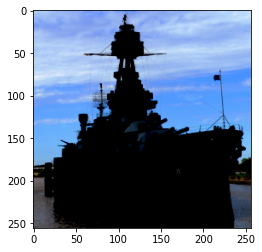

In [39]:
plt.imshow(test_image.permute(1,2,0))

In [40]:
model.eval()
output = model(torch.stack((test_image, test_image)).to(device))

Get output for image from train or test loader

In [ ]:
batch = next(iter(test_loader))
model.eval()
output = model(batch[0].to(device))

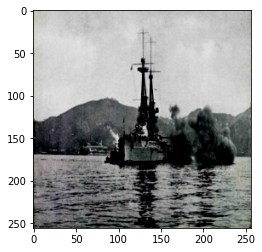

In [ ]:
plt.imshow(batch[0][7].permute(1,2,0))

Recommend articles for output

In [41]:
recommend_articles(output[0].detach(), article_embeddings, article_titles, article_contents)

tensor([0.7941, 0.8182, 0.8184, 0.8190, 0.8218, 0.8235, 0.8244, 0.8257, 0.8302,
        0.8309], device='cuda:0')
torch.return_types.topk(
values=tensor([0.7941, 0.8182, 0.8184, 0.8190, 0.8218, 0.8235, 0.8244, 0.8257, 0.8302,
        0.8309], device='cuda:0'),
indices=tensor([2350, 5185, 1970, 4341, 4982, 2893, 1208,  977, 2948, 3625],
       device='cuda:0'))
Title: Battleship
Title: South Carolina-class battleship
Title: HMS Erin
Title: Montana-class battleship
Title: North Carolina-class battleship
Title: USS Oberrender
Title: Kaiser-class battleship
Title: Indiana-class battleship
Title: Lion-class battleship
Title: Pennsylvania-class battleship
